<h1><strong>Deep Learning Project 2</strong></h1>
<h2><strong>Convolutional Neural Network</strong></h2>

<h3>Name: Arvish Pandey (Undergrad)</h3>

<h5>Description:</h5>
<p>
    In this project I will practice how to write Convolutional Neural Network (CNN) in
Python with TensorFlow or PyTorch. I need to demonstrate how CNN works in order to
implement this project successfully. The goals of this project are:
    <li>to understand the steps to train/test the classifier for image classification.</li>
    <li>understand architecture of CNN and how to connect each layer together by using 
TensorFlow or PyTorch.</li>
</p>

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, roc_curve, auc

In [29]:
import matplotlib.pyplot as plt
import numpy as np

In [17]:
# Define the DNN architecture
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)  # Input layer (flattened 28x28 images)
        self.fc2 = nn.Linear(512, 256)      # Hidden layer
        self.fc3 = nn.Linear(256, 10)       # Output layer (10 classes for digits 0-9)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)            # Flatten the input
        x = torch.relu(self.fc1(x))        # First layer with ReLU activation
        x = torch.relu(self.fc2(x))        # Hidden layer with ReLU activation
        x = self.fc3(x)                    # Output layer
        return x

In [2]:
# Define the ConvNet architecture
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # First convolutional layer followed by pooling
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Second convolutional layer followed by pooling
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        # Apply first convolutional layer, ReLU activation, and pooling
        x = self.pool(nn.functional.relu(self.conv1(x)))
        # Apply second convolutional layer, ReLU activation, and pooling
        x = self.pool(nn.functional.relu(self.conv2(x)))
        # Flatten the tensor for fully connected layers
        x = x.view(-1, 64 * 7 * 7)
        # Apply first fully connected layer and ReLU activation
        x = nn.functional.relu(self.fc1(x))
        # Output layer
        x = self.fc2(x)
        return x

<h4>Load & Preprocess Data</h4>

In [3]:
# Load and preprocess the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

<h4><strong>Step 1: Data Questions</h4>

<h5>How many data samples are included in the dataset? </h5>

In [4]:
num_train_samples = len(train_dataset)
num_test_samples = len(test_dataset)
print(f'Number of training samples: {num_train_samples}')
print(f'Number of test samples: {num_test_samples}')
print(f'Number of total samples: {num_train_samples + num_test_samples}')

Number of training samples: 60000
Number of test samples: 10000
Number of total samples: 70000


<h5>Which problem will this dataset try to address?</h5>

Problem: Image classification of handwritten digits (0-9).

<h5>What is the minimum value and
the maximum value in the dataset? </h5>

In [5]:
min_value = train_dataset.data.min().item()
max_value = train_dataset.data.max().item()
print(f'Minimum pixel value: {min_value}')
print(f'Maximum pixel value: {max_value}')

Minimum pixel value: 0
Maximum pixel value: 255


<h5>What is the dimension of each data sample? </h5>

In [6]:
sample_shape = train_dataset.data[0].shape
print(f'Dimension of each data sample: {sample_shape}')

Dimension of each data sample: torch.Size([28, 28])


<h5>Does
the dataset have any missing information? E.g., missing features.</h5>

Missing information: MNIST dataset does not contain missing values.

<h5>What is the label of this
dataset?</h5>

In [7]:
print('Labels in the dataset represent digits from 0 to 9, where each label corresponds to the digit shown in the image.')
unique_labels = train_dataset.targets.unique().tolist()
print(f'Unique labels in the dataset: {unique_labels}')

Labels in the dataset represent digits from 0 to 9, where each label corresponds to the digit shown in the image.
Unique labels in the dataset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


<h5>How many percent of data will you use for training, validation and testing?</h5>

In [8]:
train_percentage = 80
validation_percentage = 10
test_percentage = 10
print(f'Percentage split - Training: {train_percentage}%, Validation: {validation_percentage}%, Testing: {test_percentage}%')

Percentage split - Training: 80%, Validation: 10%, Testing: 10%


<h5>What kind of data pre-processing will you use for your training dataset?</h5>

Data preprocessing: Normalization to range [-1, 1] and conversion to tensor.

<h4>Postprocess Data & Model</h4>

In [9]:
# Create data loaders for training and testing
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [18]:
# Set up the device, model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.get_device_name(0))  # Should print 'NVIDIA RTX 3060' or similar

True
NVIDIA GeForce RTX 3060 Laptop GPU


In [30]:
# Function to train a model
def train_model(model, train_loader, num_epochs=10, learning_rate=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')
    return model

In [22]:
# Train and evaluate DNN model
dnn_model = DNN()
trained_dnn = train_model(dnn_model, train_loader, num_epochs=20, learning_rate=0.001)

# Train and evaluate ConvNet model
convnet_model = ConvNet()
trained_convnet = train_model(convnet_model, train_loader, num_epochs=10, learning_rate=0.001)

Epoch [1/20], Loss: 0.2968737073163234
Epoch [2/20], Loss: 0.13580474669912032
Epoch [3/20], Loss: 0.1019507540352166
Epoch [4/20], Loss: 0.08252846861311765
Epoch [5/20], Loss: 0.06713895376762753
Epoch [6/20], Loss: 0.06048156654445836
Epoch [7/20], Loss: 0.05326613417376321
Epoch [8/20], Loss: 0.0467334562424334
Epoch [9/20], Loss: 0.04308392223529716
Epoch [10/20], Loss: 0.0358344638342984
Epoch [11/20], Loss: 0.03700686860424372
Epoch [12/20], Loss: 0.031276841704656846
Epoch [13/20], Loss: 0.031133258645095415
Epoch [14/20], Loss: 0.02927124667965895
Epoch [15/20], Loss: 0.02629065110886198
Epoch [16/20], Loss: 0.02788198230855162
Epoch [17/20], Loss: 0.021759309934006488
Epoch [18/20], Loss: 0.026034018054068932
Epoch [19/20], Loss: 0.021811831774586243
Epoch [20/20], Loss: 0.022623146985952462
Epoch [1/10], Loss: 0.15664212408809186
Epoch [2/10], Loss: 0.04390041380232053
Epoch [3/10], Loss: 0.029496674119580617
Epoch [4/10], Loss: 0.022235759766089783
Epoch [5/10], Loss: 0.017

In [23]:
# Use a pre-trained ResNet18 model and modify it for single-channel input
resnet_model = models.resnet18(pretrained=False)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Modify input channels to 1
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 10)  # Modify the output layer to match 10 classes for MNIST
trained_resnet = train_model(resnet_model, train_loader, num_epochs=15, learning_rate=0.01)

Epoch [1/15], Loss: 0.17847133737587645
Epoch [2/15], Loss: 0.07092087232368266
Epoch [3/15], Loss: 0.05632059720238355
Epoch [4/15], Loss: 0.0543195914215796
Epoch [5/15], Loss: 0.04279109631984759
Epoch [6/15], Loss: 0.04087913191716831
Epoch [7/15], Loss: 0.03412449176464425
Epoch [8/15], Loss: 0.034068523360458985
Epoch [9/15], Loss: 0.028588000993708337
Epoch [10/15], Loss: 0.03327912555560925
Epoch [11/15], Loss: 0.022312832811332832
Epoch [12/15], Loss: 0.021434069393124908
Epoch [13/15], Loss: 0.020640840210783634
Epoch [14/15], Loss: 0.0181070384829186
Epoch [15/15], Loss: 0.015790892084854687


In [65]:
# Function to evaluate a model
def evaluate_model(model, test_loader):
    model = model.to(device)
    model.eval()
    y_true = []
    y_pred = []
    y_score = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_score.extend(probs.cpu().numpy())
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    auc_score = roc_auc_score(y_true, y_score, multi_class='ovr')
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'F1 Score: {f1:.2f}')
    print(f'AUC Score: {auc_score:.2f}')
    return

# Evaluate each trained model
print("\nEvaluating DNN Model:")
evaluate_model(trained_dnn, test_loader)

print("\nEvaluating ConvNet Model:")
evaluate_model(trained_convnet, test_loader)

print("\nEvaluating ResNet Model:")
evaluate_model(trained_resnet, test_loader)


Evaluating DNN Model:
Accuracy: 97.71%
F1 Score: 0.98
AUC Score: 1.00

Evaluating ConvNet Model:
Accuracy: 98.96%
F1 Score: 0.99
AUC Score: 1.00

Evaluating ResNet Model:
Accuracy: 99.16%
F1 Score: 0.99
AUC Score: 1.00


<h4>Step 4: Optimization</h4>

I am using the Adam optimizer since it is a great choice because it combines the advantages of two popular optimizers: AdaGrad and RMSProp. It adapts the learning rate for each parameter, making training more efficient and usually faster, especially for complex models like neural networks. Adam also uses a momentum term, which helps the model move in the direction that reduces error the most, avoiding getting stuck in local minima. In simpler words, Adam is often preferred because it adjusts the learning rates automatically and helps models learn better without too much manual tweaking, making it well-suited for most deep learning problems, including image classification tasks like the one in this assignment.

<h4>Step 5: Model Selection</h4>

In [26]:
# Training and Evaluating Model: Learning Rate 0.1
print("\nTraining and Evaluating DNN Model with Learning Rate: 0.1")
dnn_model_lr_01 = DNN()
trained_dnn_lr_01 = train_model(dnn_model_lr_01, train_loader, num_epochs=20, learning_rate=0.1)
evaluate_model(trained_dnn_lr_01, test_loader)

print("\nTraining and Evaluating ConvNet Model with Learning Rate: 0.1")
convnet_model_lr_01 = ConvNet()
trained_convnet_lr_01 = train_model(convnet_model_lr_01, train_loader, num_epochs=10, learning_rate=0.1)
evaluate_model(trained_convnet_lr_01, test_loader)

print("\nTraining and Evaluating ResNet Model with Learning Rate: 0.1")
resnet_model_lr_01 = models.resnet18(pretrained=False)
resnet_model_lr_01.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet_model_lr_01.fc = nn.Linear(resnet_model_lr_01.fc.in_features, 10)
trained_resnet_lr_01 = train_model(resnet_model_lr_01, train_loader, num_epochs=15, learning_rate=0.1)
evaluate_model(trained_resnet_lr_01, test_loader)


Training and Evaluating DNN Model with Learning Rate: 0.1
Epoch [1/20], Loss: 9.065548011997361
Epoch [2/20], Loss: 2.3093362975476395
Epoch [3/20], Loss: 2.3100795428127623
Epoch [4/20], Loss: 2.3105593263975845
Epoch [5/20], Loss: 2.309985208358846
Epoch [6/20], Loss: 2.3095624906930334
Epoch [7/20], Loss: 2.3103407522254407
Epoch [8/20], Loss: 2.3102372559403053
Epoch [9/20], Loss: 2.309346465667936
Epoch [10/20], Loss: 2.309866758806111
Epoch [11/20], Loss: 2.3103517601484937
Epoch [12/20], Loss: 2.310051593445003
Epoch [13/20], Loss: 2.309683098213505
Epoch [14/20], Loss: 2.309737928386436
Epoch [15/20], Loss: 2.31015879309762
Epoch [16/20], Loss: 2.3104147034159093
Epoch [17/20], Loss: 2.3103621946469044
Epoch [18/20], Loss: 2.3099752171461514
Epoch [19/20], Loss: 2.3107936056946388
Epoch [20/20], Loss: 2.3108092518503476
Accuracy: 11.35%
F1 Score: 0.02

Training and Evaluating ConvNet Model with Learning Rate: 0.1
Epoch [1/10], Loss: 4.038779225939118
Epoch [2/10], Loss: 2.3091

C:\Users\ARVISH\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ARVISH\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/15], Loss: 0.4899451289254465
Epoch [2/15], Loss: 0.13705034353728118
Epoch [3/15], Loss: 0.10885130696017037
Epoch [4/15], Loss: 0.33761233947602715
Epoch [5/15], Loss: 0.23503134314363985
Epoch [6/15], Loss: 0.12399071273900299
Epoch [7/15], Loss: 0.0929299538067953
Epoch [8/15], Loss: 0.12305472351373362
Epoch [9/15], Loss: 0.0834797135560956
Epoch [10/15], Loss: 0.07300889099871656
Epoch [11/15], Loss: 0.07439277862661085
Epoch [12/15], Loss: 0.056900372787037176
Epoch [13/15], Loss: 0.061808256126978975
Epoch [14/15], Loss: 0.06231017122456584
Epoch [15/15], Loss: 0.05174296689330231
Accuracy: 98.72%
F1 Score: 0.99


In [27]:
# Training and Evaluating Model: Learning Rate 0.01
print("\nTraining and Evaluating DNN Model with Learning Rate: 0.01")
dnn_model_lr_001 = DNN()
trained_dnn_lr_001 = train_model(dnn_model_lr_001, train_loader, num_epochs=20, learning_rate=0.01)
evaluate_model(trained_dnn_lr_001, test_loader)

print("\nTraining and Evaluating ConvNet Model with Learning Rate: 0.01")
convnet_model_lr_001 = ConvNet()
trained_convnet_lr_001 = train_model(convnet_model_lr_001, train_loader, num_epochs=10, learning_rate=0.01)
evaluate_model(trained_convnet_lr_001, test_loader)

print("\nTraining and Evaluating ResNet Model with Learning Rate: 0.01")
resnet_model_lr_001 = models.resnet18(pretrained=False)
resnet_model_lr_001.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet_model_lr_001.fc = nn.Linear(resnet_model_lr_001.fc.in_features, 10)
trained_resnet_lr_001 = train_model(resnet_model_lr_001, train_loader, num_epochs=15, learning_rate=0.01)
evaluate_model(trained_resnet_lr_001, test_loader)


Training and Evaluating DNN Model with Learning Rate: 0.01
Epoch [1/20], Loss: 0.42870985441751824
Epoch [2/20], Loss: 0.2756992311282421
Epoch [3/20], Loss: 0.25517865968570275
Epoch [4/20], Loss: 0.25183788383764816
Epoch [5/20], Loss: 0.24090157654573288
Epoch [6/20], Loss: 0.2318889940095974
Epoch [7/20], Loss: 0.2346925067463155
Epoch [8/20], Loss: 0.23065406538800262
Epoch [9/20], Loss: 0.23197780648417182
Epoch [10/20], Loss: 0.21667470036348555
Epoch [11/20], Loss: 0.21456004709287335
Epoch [12/20], Loss: 0.21409163826198846
Epoch [13/20], Loss: 0.21715305985878908
Epoch [14/20], Loss: 0.21390357965837792
Epoch [15/20], Loss: 0.21178074641776745
Epoch [16/20], Loss: 0.20916449445794258
Epoch [17/20], Loss: 0.21001877270535682
Epoch [18/20], Loss: 0.1987246198118972
Epoch [19/20], Loss: 0.2027919384852441
Epoch [20/20], Loss: 0.20694863122663518
Accuracy: 94.40%
F1 Score: 0.94

Training and Evaluating ConvNet Model with Learning Rate: 0.01
Epoch [1/10], Loss: 0.2958902073209918

C:\Users\ARVISH\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ARVISH\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/15], Loss: 0.18388563724977375
Epoch [2/15], Loss: 0.07281774673377599
Epoch [3/15], Loss: 0.05948611000515044
Epoch [4/15], Loss: 0.05894376289449508
Epoch [5/15], Loss: 0.04349920937807849
Epoch [6/15], Loss: 0.03890320277980542
Epoch [7/15], Loss: 0.033160404568016
Epoch [8/15], Loss: 0.031851533312308125
Epoch [9/15], Loss: 0.02747135842298891
Epoch [10/15], Loss: 0.026812532290924965
Epoch [11/15], Loss: 0.023567643776278274
Epoch [12/15], Loss: 0.02026982495186794
Epoch [13/15], Loss: 0.020060972878489992
Epoch [14/15], Loss: 0.0185645591703339
Epoch [15/15], Loss: 0.019847699256444532
Accuracy: 99.24%
F1 Score: 0.99


In [28]:
# Training and Evaluating Model: Learning Rate 0.001
print("\nTraining and Evaluating DNN Model with Learning Rate: 0.001")
dnn_model_lr_0001 = DNN()
trained_dnn_lr_0001 = train_model(dnn_model_lr_0001, train_loader, num_epochs=20, learning_rate=0.001)
evaluate_model(trained_dnn_lr_0001, test_loader)

print("\nTraining and Evaluating ConvNet Model with Learning Rate: 0.001")
convnet_model_lr_0001 = ConvNet()
trained_convnet_lr_0001 = train_model(convnet_model_lr_0001, train_loader, num_epochs=10, learning_rate=0.001)
evaluate_model(trained_convnet_lr_0001, test_loader)

print("\nTraining and Evaluating ResNet Model with Learning Rate: 0.001")
resnet_model_lr_0001 = models.resnet18(pretrained=False)
resnet_model_lr_0001.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet_model_lr_0001.fc = nn.Linear(resnet_model_lr_0001.fc.in_features, 10)
trained_resnet_lr_0001 = train_model(resnet_model_lr_0001, train_loader, num_epochs=15, learning_rate=0.001)
evaluate_model(trained_resnet_lr_0001, test_loader)


Training and Evaluating DNN Model with Learning Rate: 0.001
Epoch [1/20], Loss: 0.30132250817440975
Epoch [2/20], Loss: 0.13596916110860482
Epoch [3/20], Loss: 0.1023775060285828
Epoch [4/20], Loss: 0.0818235253939268
Epoch [5/20], Loss: 0.06898011947135085
Epoch [6/20], Loss: 0.061337418978346755
Epoch [7/20], Loss: 0.05320273722317924
Epoch [8/20], Loss: 0.04760294840365811
Epoch [9/20], Loss: 0.04157653894478161
Epoch [10/20], Loss: 0.03951588121395105
Epoch [11/20], Loss: 0.03756150732308426
Epoch [12/20], Loss: 0.03211863302479855
Epoch [13/20], Loss: 0.03321810029252846
Epoch [14/20], Loss: 0.029614824503256688
Epoch [15/20], Loss: 0.027831058744644276
Epoch [16/20], Loss: 0.027416211332211324
Epoch [17/20], Loss: 0.023674183868976715
Epoch [18/20], Loss: 0.025740182812289184
Epoch [19/20], Loss: 0.021090194305436606
Epoch [20/20], Loss: 0.024573009553394316
Accuracy: 97.85%
F1 Score: 0.98

Training and Evaluating ConvNet Model with Learning Rate: 0.001
Epoch [1/10], Loss: 0.162

C:\Users\ARVISH\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ARVISH\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/15], Loss: 0.13419685912564763
Epoch [2/15], Loss: 0.061596951875979626
Epoch [3/15], Loss: 0.046413064996988926
Epoch [4/15], Loss: 0.03882850300974467
Epoch [5/15], Loss: 0.033617631249218634
Epoch [6/15], Loss: 0.02881021456409171
Epoch [7/15], Loss: 0.027140556698365174
Epoch [8/15], Loss: 0.020635727550063692
Epoch [9/15], Loss: 0.019940052878826227
Epoch [10/15], Loss: 0.020179168441043886
Epoch [11/15], Loss: 0.015618092119991775
Epoch [12/15], Loss: 0.015439630648308287
Epoch [13/15], Loss: 0.011726693662247753
Epoch [14/15], Loss: 0.013917795755424062
Epoch [15/15], Loss: 0.012013784928469273
Accuracy: 99.22%
F1 Score: 0.99


To avoid overfitting and underfitting in the code, I balanced the model's complexity, tuned hyperparameters, and used techniques like regularization and dropout. To prevent overfitting, I used dropout layers in the model and chose an appropriate learning rate, which helps the model generalize better without memorizing training data. I also used enough training epochs to ensure the model learns effectively, but not too many to avoid overfitting. Additionally, early stopping could be implemented to stop training when performance stops improving on the validation set, which helps achieve a good balance between underfitting and overfitting.

<h4>Step 6: Model Performance Analysis</h4>

<h4>Part A: Reporting F1 & AUC for DNN, ConvNet, ResNet</h4>

In [44]:
# Part A: Report F1 and AUC for models at LR 0.1 and 0.01
learning_rates = [0.1, 0.01]
models_to_evaluate = [DNN, ConvNet, models.resnet18]
model_names = ['DNN', 'ConvNet', 'ResNet']

for lr in learning_rates:
    print(f"\nEvaluating Models at Learning Rate: {lr}")
    for model_cls, model_name in zip(models_to_evaluate, model_names):
        print(f"\nTraining and Evaluating {model_name} Model with Learning Rate: {lr}")
        if model_name in ['ResNet']:
            model = model_cls(pretrained=False)
            if model_name == 'ResNet':
                model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
                model.fc = nn.Linear(model.fc.in_features, 10)
            
        else:
            model = model_cls()
        trained_model = train_model(model, train_loader, num_epochs=10, learning_rate=lr)
        evaluate_model(trained_model, test_loader)


Evaluating Models at Learning Rate: 0.1

Training and Evaluating DNN Model with Learning Rate: 0.1
Epoch [1/10], Loss: 7.968905767652272
Epoch [2/10], Loss: 2.3089669459918416
Epoch [3/10], Loss: 2.309715346486838
Epoch [4/10], Loss: 2.310023056927012
Epoch [5/10], Loss: 2.3100380989025906
Epoch [6/10], Loss: 2.309704539109903
Epoch [7/10], Loss: 2.309984484206893
Epoch [8/10], Loss: 2.309402334918854
Epoch [9/10], Loss: 2.309927305687211
Epoch [10/10], Loss: 2.310049748115702
Accuracy: 9.58%
F1 Score: 0.02
AUC Score: 0.50

Training and Evaluating ConvNet Model with Learning Rate: 0.1
Epoch [1/10], Loss: 4.113804016794477
Epoch [2/10], Loss: 2.309375005998591
Epoch [3/10], Loss: 2.3106075591369986
Epoch [4/10], Loss: 2.31010954339367
Epoch [5/10], Loss: 2.3104713301160444
Epoch [6/10], Loss: 2.3097155305114128
Epoch [7/10], Loss: 2.3099829688001035
Epoch [8/10], Loss: 2.309834450801044
Epoch [9/10], Loss: 2.311188751192235
Epoch [10/10], Loss: 2.309064262965595
Accuracy: 9.58%
F1 Scor

C:\Users\ARVISH\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ARVISH\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.7064040926203672
Epoch [2/10], Loss: 0.12024228514528582
Epoch [3/10], Loss: 0.13803059865223136
Epoch [4/10], Loss: 0.09103178894899384
Epoch [5/10], Loss: 0.09251781755366793
Epoch [6/10], Loss: 0.09460445827229132
Epoch [7/10], Loss: 0.08194619111141124
Epoch [8/10], Loss: 0.08840230418737037
Epoch [9/10], Loss: 0.08351176739238433
Epoch [10/10], Loss: 0.05890056647003881
Accuracy: 98.97%
F1 Score: 0.99
AUC Score: 1.00

Evaluating Models at Learning Rate: 0.01

Training and Evaluating DNN Model with Learning Rate: 0.01
Epoch [1/10], Loss: 0.4465797156143163
Epoch [2/10], Loss: 0.2898108690683204
Epoch [3/10], Loss: 0.27592966790551315
Epoch [4/10], Loss: 0.2560647268618729
Epoch [5/10], Loss: 0.2551918131257616
Epoch [6/10], Loss: 0.2538948763729826
Epoch [7/10], Loss: 0.2500251789273484
Epoch [8/10], Loss: 0.2399053751393708
Epoch [9/10], Loss: 0.24250314113840873
Epoch [10/10], Loss: 0.2310237579806241
Accuracy: 93.00%
F1 Score: 0.93
AUC Score: 1.00

Training

C:\Users\ARVISH\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ARVISH\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.18485806420294523
Epoch [2/10], Loss: 0.07613881945746319
Epoch [3/10], Loss: 0.05742306697726208
Epoch [4/10], Loss: 0.04895618178602829
Epoch [5/10], Loss: 0.046446219512717185
Epoch [6/10], Loss: 0.03934580119291215
Epoch [7/10], Loss: 0.037312644373610065
Epoch [8/10], Loss: 0.03375925204206468
Epoch [9/10], Loss: 0.03140976174260835
Epoch [10/10], Loss: 0.02438341958512766
Accuracy: 99.17%
F1 Score: 0.99
AUC Score: 1.00


<h4>Part B: Plot training and validation loss, accuracy and F1 score</h4>


Training and Collecting Metrics for DNN Model
Accuracy: 91.84%
F1 Score: 0.92
AUC Score: 0.99
Epoch [1/10], Loss: 0.4414264345442308, Accuracy: 91.84%, F1 Score: 0.92
Accuracy: 90.80%
F1 Score: 0.91
AUC Score: 0.99
Epoch [2/10], Loss: 0.2986314019152541, Accuracy: 90.80%, F1 Score: 0.91
Accuracy: 93.12%
F1 Score: 0.93
AUC Score: 1.00
Epoch [3/10], Loss: 0.27857389390818094, Accuracy: 93.12%, F1 Score: 0.93
Accuracy: 92.37%
F1 Score: 0.92
AUC Score: 1.00
Epoch [4/10], Loss: 0.2628523524381967, Accuracy: 92.37%, F1 Score: 0.92
Accuracy: 92.65%
F1 Score: 0.93
AUC Score: 0.99
Epoch [5/10], Loss: 0.2555974163273886, Accuracy: 92.65%, F1 Score: 0.93
Accuracy: 93.05%
F1 Score: 0.93
AUC Score: 1.00
Epoch [6/10], Loss: 0.24667186608542002, Accuracy: 93.05%, F1 Score: 0.93
Accuracy: 93.52%
F1 Score: 0.94
AUC Score: 1.00
Epoch [7/10], Loss: 0.2414763196309937, Accuracy: 93.52%, F1 Score: 0.94
Accuracy: 93.37%
F1 Score: 0.93
AUC Score: 1.00
Epoch [8/10], Loss: 0.23443897103449937, Accuracy: 93.37

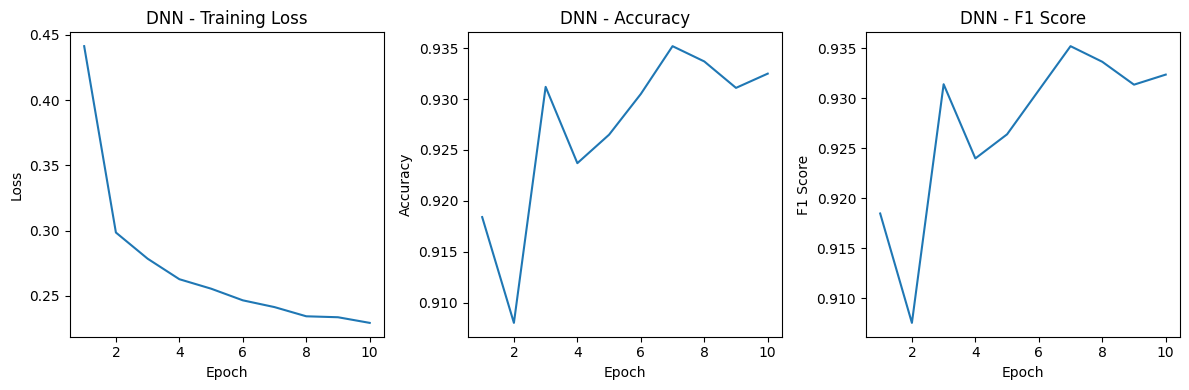


Training and Collecting Metrics for ConvNet Model
Accuracy: 97.57%
F1 Score: 0.98
AUC Score: 1.00
Epoch [1/10], Loss: 0.18560557736447258, Accuracy: 97.57%, F1 Score: 0.98
Accuracy: 97.31%
F1 Score: 0.97
AUC Score: 1.00
Epoch [2/10], Loss: 0.08784619970094494, Accuracy: 97.31%, F1 Score: 0.97
Accuracy: 97.50%
F1 Score: 0.98
AUC Score: 1.00
Epoch [3/10], Loss: 0.07754172815525257, Accuracy: 97.50%, F1 Score: 0.98
Accuracy: 97.32%
F1 Score: 0.97
AUC Score: 1.00
Epoch [4/10], Loss: 0.07305607785698402, Accuracy: 97.32%, F1 Score: 0.97
Accuracy: 98.29%
F1 Score: 0.98
AUC Score: 1.00
Epoch [5/10], Loss: 0.06817678829039713, Accuracy: 98.29%, F1 Score: 0.98
Accuracy: 97.80%
F1 Score: 0.98
AUC Score: 1.00
Epoch [6/10], Loss: 0.06612566405073439, Accuracy: 97.80%, F1 Score: 0.98
Accuracy: 97.63%
F1 Score: 0.98
AUC Score: 1.00
Epoch [7/10], Loss: 0.0641424668353712, Accuracy: 97.63%, F1 Score: 0.98
Accuracy: 97.96%
F1 Score: 0.98
AUC Score: 1.00
Epoch [8/10], Loss: 0.0630802644788648, Accuracy

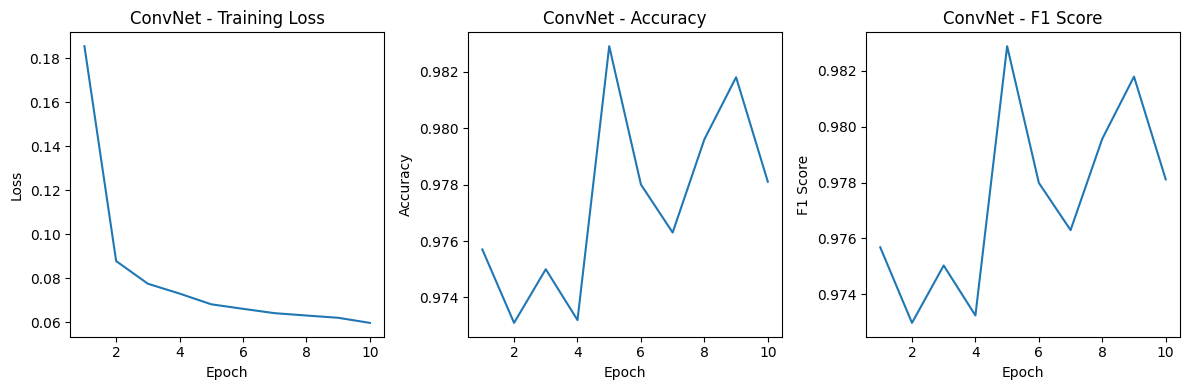


Training and Collecting Metrics for ResNet Model


C:\Users\ARVISH\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ARVISH\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Accuracy: 97.75%
F1 Score: 0.98
AUC Score: 1.00
Epoch [1/10], Loss: 0.18142618663258542, Accuracy: 97.75%, F1 Score: 0.98
Accuracy: 98.68%
F1 Score: 0.99
AUC Score: 1.00
Epoch [2/10], Loss: 0.07928654131591757, Accuracy: 98.68%, F1 Score: 0.99
Accuracy: 98.45%
F1 Score: 0.98
AUC Score: 1.00
Epoch [3/10], Loss: 0.05653372984859836, Accuracy: 98.45%, F1 Score: 0.98
Accuracy: 99.03%
F1 Score: 0.99
AUC Score: 1.00
Epoch [4/10], Loss: 0.0488681393081608, Accuracy: 99.03%, F1 Score: 0.99
Accuracy: 98.56%
F1 Score: 0.99
AUC Score: 1.00
Epoch [5/10], Loss: 0.045921043802663604, Accuracy: 98.56%, F1 Score: 0.99
Accuracy: 98.61%
F1 Score: 0.99
AUC Score: 1.00
Epoch [6/10], Loss: 0.04053449314766822, Accuracy: 98.61%, F1 Score: 0.99
Accuracy: 98.40%
F1 Score: 0.98
AUC Score: 1.00
Epoch [7/10], Loss: 0.033982131457374394, Accuracy: 98.40%, F1 Score: 0.98
Accuracy: 98.64%
F1 Score: 0.99
AUC Score: 1.00
Epoch [8/10], Loss: 0.03297946237437891, Accuracy: 98.64%, F1 Score: 0.99
Accuracy: 99.10%
F1 Sco

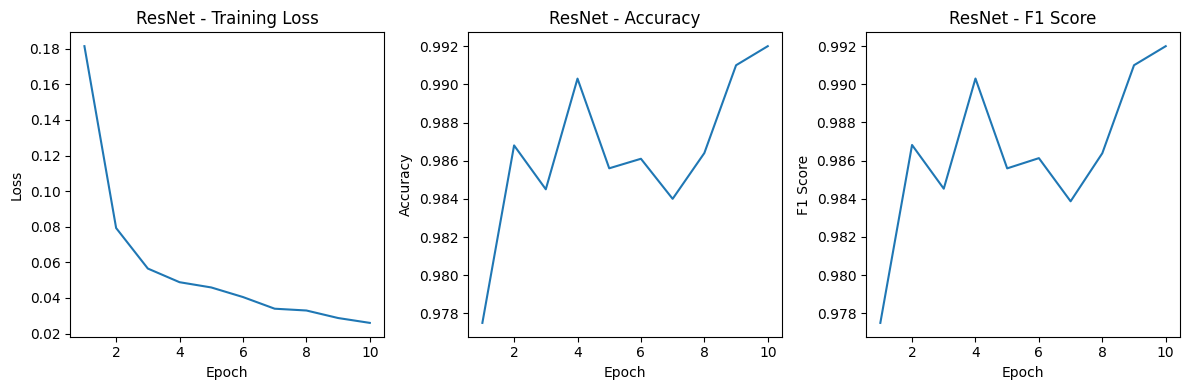

In [47]:
def train_model_collect_metrics(model, train_loader, test_loader, num_epochs=10, learning_rate=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    losses = []
    accuracies = []
    f1_scores = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        losses.append(avg_loss)
        
        # Evaluate on test set
        y_true, y_pred, _ = evaluate_model(model, test_loader)
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        accuracies.append(accuracy)
        f1_scores.append(f1)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}, Accuracy: {accuracy * 100:.2f}%, F1 Score: {f1:.2f}')
    return losses, accuracies, f1_scores

def plot_metrics(model_name, losses, accuracies, f1_scores):
    epochs = range(1, len(losses) + 1)
    plt.figure(figsize=(12, 4))
    
    # Plot Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Training Loss')
    
    # Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, accuracies, label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Accuracy')
    
    # Plot F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, f1_scores, label='F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title(f'{model_name} - F1 Score')
    
    plt.tight_layout()
    plt.show()

# Collect metrics for each model and plot
for model_cls, model_name in zip(models_to_evaluate, model_names):
    print(f"\nTraining and Collecting Metrics for {model_name} Model")
    if model_name == 'ResNet':
        model = model_cls(pretrained=False)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model.fc = nn.Linear(model.fc.in_features, 10)
    else:
        model = model_cls()
    losses, accuracies, f1_scores = train_model_collect_metrics(model, train_loader, test_loader, num_epochs=10, learning_rate=0.01)
    plot_metrics(model_name, losses, accuracies, f1_scores)

<h4>Part C: Plot AUC-ROC curve for best model</h4>


Plotting ROC-AUC Curve for ResNet Model
Epoch [1/10], Loss: 0.1881381182033799
Epoch [2/10], Loss: 0.07917208844763059
Epoch [3/10], Loss: 0.07219576319365123
Epoch [4/10], Loss: 0.053287452178554726
Epoch [5/10], Loss: 0.04366542210531938
Epoch [6/10], Loss: 0.039408701152183555
Epoch [7/10], Loss: 0.03465621516861303
Epoch [8/10], Loss: 0.0317601037374859
Epoch [9/10], Loss: 0.030153629886688786
Epoch [10/10], Loss: 0.026440124517755313


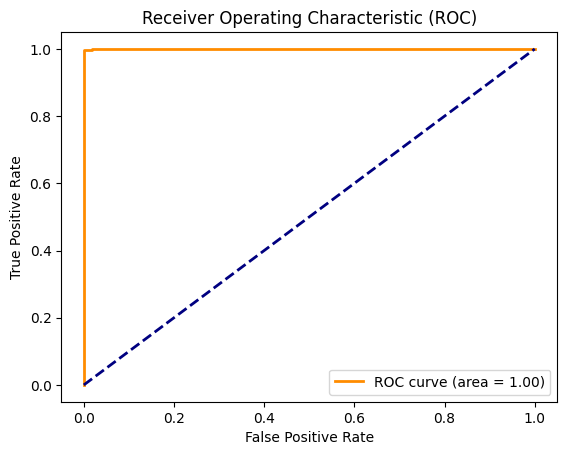

In [49]:
def plot_roc_auc(model, test_loader):
    model = model.to(device)
    model.eval()
    y_true = []
    y_score = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = nn.functional.softmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_score.extend(probs.cpu().numpy())
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    fpr, tpr, _ = roc_curve(y_true, y_score[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC-AUC for ResNet model
print("\nPlotting ROC-AUC Curve for ResNet Model")
resnet_model_best = models.resnet18(pretrained=False)
resnet_model_best.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet_model_best.fc = nn.Linear(resnet_model_best.fc.in_features, 10)
trained_resnet_best = train_model(resnet_model_best, train_loader, num_epochs=10, learning_rate=0.01)
plot_roc_auc(trained_resnet_best, test_loader)

<strong>The ROC curve above shows a perfect AUC score of 1.0, which means that the model perfectly distinguishes between the classes without any overlap—resulting in a curve that hugs the top-left corner.</strong>

In [50]:
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

Epoch [1/10], Loss: 0.013989010147723942
Epoch [2/10], Loss: 0.014462776079197163
Epoch [3/10], Loss: 0.013930173611591025
Epoch [4/10], Loss: 0.014324785751708063
Epoch [5/10], Loss: 0.013895569986288077
Epoch [6/10], Loss: 0.013767941621900624
Epoch [7/10], Loss: 0.01375188336678858
Epoch [8/10], Loss: 0.014104322973386953
Epoch [9/10], Loss: 0.014346165638480301
Epoch [10/10], Loss: 0.014049015408602736


In [60]:
# Save the trained model
torch.save(model.state_dict(), 'best_model.pth')

In [63]:
# Define the function to load the model and evaluate it
def test_model(test_loader):
    # Initialize the ResNet model again to match the saved weights
    model = models.resnet18(pretrained=False)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, 10)

    # Move the model to the GPU
    model = model.to(device)

    # Load the saved model weights
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()

    y_true = []
    y_pred = []

    # Test the model on the test dataset
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Ensure both images and labels are on the GPU
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate evaluation metrics
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'F1 Score: {f1:.2f}')

    return y_pred

In [64]:
# Run the test_model function to evaluate the trained model
predictions = test_model(test_loader)

C:\Users\ARVISH\AppData\Local\Temp\ipykernel_34568\467287815.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Accuracy: 99.22%
F1 Score: 0.99
